In [5]:
#Stochastic with Delay and Isolation and a waiting for test compartment No persistance , Verion 4

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint



#Non-Stochastic Parameters Parameters

N = 250000          #250000               # Total population
p_3months = 0.3         # Proportion tested every 3 months
p_12months = 1-p_3months         # Proportion tested every 12 months
tau = 7                # This is our key parameter; the average return time for tests.

# The (weighted) average testing proportion for our population (proportion per day)
average_daily_testing_proportion = (p_3months/91 + p_12months/365)
tests_per_day=N*average_daily_testing_proportion
# I think that the generic person will get tested with this probability each day, and so the waiting
# time for a test from any given instant is 1/average_testing_proportion (exponential waiting time)
# No.... maybe it should be with rate tests_per_day??

# Initial conditions
E0 = 0.1 * N             # Initial exposed individuals.
X0 = N - E0              # Initial susceptible individuals.
S0 = 0                   # Initial symptomatic individuals (we assume the symptoms are NOTICEABLE). Symptomatic Individuals are assumed to isolate.
A_u0 = 0               # Initial asymptomatic individuals who are untested.
A_t0 = 0                 # Initial asympt. who are tested and awating a positive. These individuals will NOT isolate. 
A_pos0 = 0                 # Initial asympt. positive test. These people are isolating. 
                   # Initial people with complications 

#note: we will assume perfect isolation
#note: since we are assuming routine testing, we assume that testees do not change their habits unless
#      they receive a positive test. 
#note: We assume that people who become symptomatic right away are unlikely to develop severe disease. 

#Initial Stochastic parameters:


#beta is the transmission rate, infection probability is beta with mean 0.8
# times (3 partners per month) distributed like a gamma dist. 
beta = 0.9*2.85
# Rate of progression from exposed to infectious. We assume exposed individuals are not transmitting. 
# Duration here is assumed to be gamma. Small constant added for numerical stability
epsilon =1/5

# Recovery rate for individuals undergoing treatment. 
# Assumed to be gamma with mean 7 days+- 1 day. Small constant added for numerical stability
gamma_t = 1/7

# proportion of infected, asymptomatic individuals who become symptomaitc. Assumed to be 
# beta with expected value 0.10 (10% chance)
theta=0.1

# Natural recovery rate for untreated individuals who will self-clear (estimated to be about 2 weeks) !!Find Ref!
# Assumed to be gamma. Small constant added for numerical stability. 
gamma_u = 1/14

# Proportion developing asymptomatic infection
# Assumed to be beta with expected value 0.8 and variance 0.01
lambda_ = 0.8

# Amount of time someone should wait until their next test:
# Assumed to be exponential with rate average_testing_proportion.
# small constant added for numerical stability
omega_t = 1/tests_per_day #not sure if I need this guy... 

# #Rate of test return. 1/wait time to return tests
# Assumed to be gamma with expected value tau and variance 1. Small constant added for numerical stability.
omega_r = 1/tau
# THIS is the key value. 

# Risk of complications
# Assumed to be beta with expected value 0.0225
#eta = np.random.beta(estBetaParams(0.0225,0.0075**2)[0],estBetaParams(0.0225,0.0075**2)[1])
#Not necessary. factor into the final prediction. 
    

In [53]:

#Define the Model 

def model(Y, t, beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion , tau, N):
  
    
    X, E, S, A_u, A_t, A_pos= Y
    
    
    # Here, we assume that the only groups driving the spread of infection are the asymptomatic who have not received a positive test
    dXdt = -beta*X*(A_u+A_t)/N + gamma_t*S  + gamma_t*A_pos + gamma_u*A_t + (1-theta)*gamma_u*A_u
    
    
    dEdt = beta*X*(A_u+A_t)/N - epsilon*E
    
    
    dSdt = (1-lambda_)*epsilon*E + theta*gamma_u*A_u - gamma_t*S 
     
    
    dA_udt = lambda_*epsilon*E - average_daily_testing_proportion*A_u - gamma_u*A_u #I want some proportion to clear, and some proportion to become infectious
    
    dA_tdt = average_daily_testing_proportion*A_u - omega_r*A_t - gamma_u*A_t
    
    
    dA_posdt = omega_r*A_t - gamma_t*A_pos
    
    
    
    
    return [dXdt, dEdt, dSdt, dA_udt, dA_tdt, dA_posdt]



In [54]:
#Simulation 

# Time array: Simulate over 10 years

print("hello world..")

t_points = np.linspace(0, 5 * 365, 5 * 365)


# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

# Loop over each day and solve the ODEs
solution = np.zeros((len(t_points), 6))
solution[0] = [X0, E0, S0, A_u0, A_t0, A_pos0]


epsilons=[] #we will average these to calculate total cases later. 
lambdas=[]
for i in range(1, len(t_points)):
    
    
    tspan = [t_points[i-1], t_points[i]]
    
    ys = odeint(model, solution[i-1], tspan, args=(beta, epsilon, gamma_t, gamma_u, lambda_, theta, omega_r, average_daily_testing_proportion, tau, N), atol=abserr, rtol=relerr)
    
     # Update the solution
    solution[i] = ys[-1]
    print(i, solution[i], sum(solution[i]))
    
    
    

hello world..
1 [2.20873496e+05 2.45025505e+04 9.09357210e+02 3.70501748e+03
 9.14653753e+00 4.32594245e-01] 250000.0
2 [2.08997142e+05 3.14502377e+04 1.85161050e+03 7.66379701e+03
 3.40881447e+01 3.12481566e+00] 250000.0
3 [1.89186778e+05 4.47426119e+04 3.08080809e+03 1.29043634e+04
 7.55659020e+01 9.87258604e+00] 250000.0
4 [1.61232153e+05 6.35602717e+04 4.79299676e+03 2.02534487e+04
 1.38492857e+02 2.26370365e+01] 249999.99999999994
5 [1.26648609e+05 8.57046581e+04 7.11055524e+03 3.02620990e+04
 2.30125020e+02 4.39535658e+01] 250000.00000000003
6 [8.98957826e+04 1.06726529e+05 1.00165915e+04 4.29263976e+04
 3.57682899e+02 7.70160085e+01] 250000.00000000003
7 [ 57363.1636571  121235.17310283  13301.64348238  57449.56769962
    525.08424679    125.36781128] 250000.00000000003
8 [ 33904.65665559 126162.65315895  16609.3357461   72401.11215376
    730.04087865    192.20140696] 250000.00000000006
9 [ 20172.68186883 122684.0087068   19587.00905001  86313.16113738
    963.62656186    279.5

   3424.30413556   3424.30413556] 250000.00000000017
191 [  9115.78063674  67406.9848896   25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.0000000002
192 [  9115.78063672  67406.98488963  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.0000000002
193 [  9115.7806341   67406.98489269  25909.89245632 140718.73374578
   3424.30413556   3424.30413556] 250000.0000000002
194 [  9115.78063609  67406.98489036  25909.89245638 140718.73374605
   3424.30413556   3424.30413556] 250000.00000000023
195 [  9115.78063656  67406.98488981  25909.8924564  140718.73374611
   3424.30413556   3424.30413556] 250000.00000000023
196 [  9115.78063667  67406.98488968  25909.8924564  140718.73374612
   3424.30413556   3424.30413556] 250000.0000000002
197 [  9115.7806367   67406.98488965  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000023
198 [  9115.78063928  67406.98488664  25909.89245649 140718.73374647
   3424.30413556   3424.3041

319 [  9115.78063714  67406.98486382  25909.89246248 140718.73376548
   3424.30413423   3424.30413685] 250000.0000000004
320 [  9115.78063704  67406.98487019  25909.89246098 140718.7337607
   3424.30413456   3424.30413653] 250000.00000000038
321 [  9115.78063695  67406.98487499  25909.89245985 140718.73375711
   3424.3041348    3424.30413629] 250000.0000000004
322 [  9115.78063689  67406.98487861  25909.892459   140718.7337544
   3424.30413499   3424.30413611] 250000.00000000044
323 [  9115.78063685  67406.98488133  25909.89245836 140718.73375236
   3424.30413513   3424.30413597] 250000.00000000044
324 [  9115.78063681  67406.98488338  25909.89245788 140718.73375082
   3424.30413523   3424.30413587] 250000.0000000005
325 [  9115.78063679  67406.98488492  25909.89245752 140718.73374966
   3424.30413531   3424.30413579] 250000.00000000047
326 [  9115.78063677  67406.98488609  25909.89245724 140718.73374879
   3424.30413537   3424.30413574] 250000.00000000047
327 [  9115.78063675  67406.9

   3424.30413556   3424.30413556] 250000.00000000038
514 [  9115.78063671  67406.98488965  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
515 [  9115.78063671  67406.98488965  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
516 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
517 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
518 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000032
519 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
520 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
521 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.

   3424.30413556   3424.30413556] 250000.00000000038
711 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
712 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
713 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
714 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
715 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
716 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
717 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
718 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.

879 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
880 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
881 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
882 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
883 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
884 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
885 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
886 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000038
887 [  9115.78063671  67

   3424.30413556   3424.30413556] 250000.00000000035
1038 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1039 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1040 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1041 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1042 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1043 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1044 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1045 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556

1132 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1133 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1134 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1135 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1136 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1137 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1138 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1139 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1140 [  9115.780

1237 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1238 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1239 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1240 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1241 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1242 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1243 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1244 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1245 [  9115.780

1344 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1345 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1346 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1347 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1348 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1349 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1350 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1351 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1352 [  9115.780

   3424.30413556   3424.30413556] 250000.00000000035
1417 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1418 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1419 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1420 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1421 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1422 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1423 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1424 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556

   3424.30413556   3424.30413556] 250000.00000000035
1533 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1534 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1535 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1536 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1537 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1538 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1539 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1540 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556

   3424.30413556   3424.30413556] 250000.00000000035
1626 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1627 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1628 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1629 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1630 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1631 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1632 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1633 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556

1715 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1716 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1717 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1718 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1719 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1720 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1721 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1722 [  9115.78063671  67406.98488964  25909.89245641 140718.73374613
   3424.30413556   3424.30413556] 250000.00000000035
1723 [  9115.780

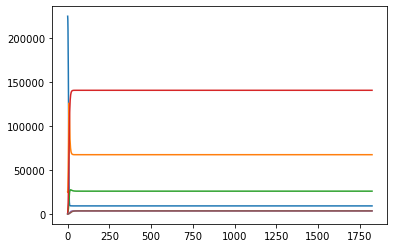

In [55]:
#rescale to be a proportion of the population
#solution=solution/N
plt.plot(solution[0:])


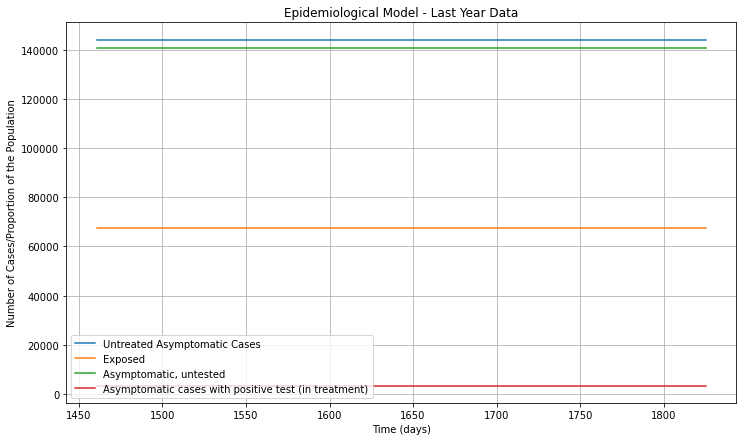

In [56]:


import matplotlib.pyplot as plt

# Extract the last year's data
last_year_data = solution[-365:]

# Separate data for different cases
symptomatic_cases = last_year_data[:, 2]
exposed_cases = last_year_data[:,1]
susceptible_cases = last_year_data[:,0]
asymptomatic_untested=last_year_data[:,3]
asymptomatic_cases_awaiting_pos=last_year_data[:,4]
asymptomatic_cases_in_treatment = last_year_data[:, 5]

untreated_asymptomatic_cases = asymptomatic_untested + asymptomatic_cases_awaiting_pos

# Time points for the last year
time_last_year = t_points[-365:]

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(time_last_year, untreated_asymptomatic_cases, label='Untreated Asymptomatic Cases')
plt.plot(time_last_year, exposed_cases, label='Exposed')
plt.plot(time_last_year, asymptomatic_untested, label='Asymptomatic, untested')
plt.plot(time_last_year, asymptomatic_cases_in_treatment, label='Asymptomatic cases with positive test (in treatment)')
plt.xlabel('Time (days)')
plt.ylabel('Number of Cases/Proportion of the Population')
plt.title('Epidemiological Model - Last Year Data')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Initialize lists to store flows for each compartment
inflow_to_E = []
inflow_to_S = []
inflow_to_A_u = []
inflow_to_A_t = []
inflow_to_A_pos = []

# Loop over the solution to calculate flows at each time step
for i in range(len(solution) - 1):  # Assuming 'solution' is your array of compartment sizes over time
    X, E, S, A_u, A_t, A_pos = solution[i]
    
    # Calculate inflow to each compartment at this time step
    inflow_to_E.append(beta*X*(A_u+A_t)/N)
    inflow_to_S.append((1-lambda_)*epsilon*E + theta*gamma_u*A_u)
    inflow_to_A_u.append(lambda_*epsilon*E)
    inflow_to_A_t.append(average_daily_testing_proportion*A_u)
    inflow_to_A_pos.append(omega_r*A_t)

# Now sum these inflows over the last year (assuming the last 365 days)
total_inflow_E = np.sum(inflow_to_E[-365:])
total_inflow_S = np.sum(inflow_to_S[-365:])
total_inflow_A_u = np.sum(inflow_to_A_u[-365:])
total_inflow_A_t = np.sum(inflow_to_A_t[-365:])
total_inflow_A_pos = np.sum(inflow_to_A_pos[-365:])

# Print the total entries for each compartment
print("Total entries into Symptomatic compartment:", total_inflow_S)
print("Total entries into Exposed compartment:", total_inflow_E)
#print("Total entries into Susceptible compartment:", total_susceptible_cases)
print("Total entries into Asymptomatic, untested compartment:", total_inflow_A_u)
print("Total entries into Asymptomatic, awaiting positive test compartment:", total_inflow_A_t)
print("Total entries into Asymptomatic, in treatment compartment:", total_inflow_A_pos)
print("Total Detected Cases:",total_inflow_S+total_inflow_A_pos)


Total entries into Symptomatic compartment: 1351015.820941189
Total entries into Exposed compartment: 4920709.896943921
Total entries into Asymptomatic, untested compartment: 3936567.9175551385
Total entries into Asymptomatic, awaiting positive test compartment: 267829.50203109137
Total entries into Asymptomatic, in treatment compartment: 178553.001354061
Total Detected Cases: 1529568.8222952501


In [58]:
1529568.8222952501/4920709.896943921

0.3108431210799912

In [1]:
def estGammaParams(mu,var):
    shape=(mu**2)/var
    scale=var/mu
    return shape, scale

In [3]:
estGammaParams(3,10)

(0.9, 3.3333333333333335)

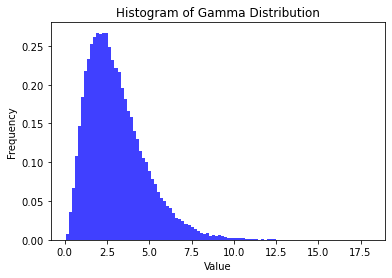

In [18]:
# Parameters for the gamma distribution: shape and scale
shape, scale = estGammaParams(3.05,3)  

# Generate a sample of size 1000 from the gamma distribution
data = np.random.gamma(shape, scale, 100000)

# Plot the histogram
plt.hist(data, bins=100, alpha=0.75, color='blue', density=True)

# Add title and labels
plt.title('Histogram of Gamma Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()